# Optimiser son code

In [59]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib inline


def eval_pixel(row, col, grid, next_grid):
    """Follows the rules of Conway's game of life to
    flip (or not) a pixel in a grid
    """
    n, m = grid.shape
    sub_grid = grid[
        max(row-1, 0): min(n, row+2),
        max(col-1, 0): min(m, col+2)]
    if grid[row, col] and not (2 < sub_grid.sum() < 5):
        next_grid[row, col] = 0
    elif sub_grid.sum() == 3:
        next_grid[row, col] = 1


def conway_step(grid):
    """Applies Conway's rule for every pixel on a grid
    """
    ii, jj = np.meshgrid(
        np.arange(grid.shape[0]),
        np.arange(grid.shape[1]) )

    next_grid = grid.copy()
    for i, j in zip(ii.ravel(), jj.ravel()):
        eval_pixel(i, j, grid, next_grid)
    return next_grid


def conway_loop(grid, ax=None):
    """Play Conways game of life on repeat
    """
    
    while True:
        try:
            grid = conway_step(grid)
            fig, ax = show_conway(grid, None)
            time.sleep(1)

        except KeyboardInterrupt:
            print('Done')
            break

def show_conway(grid, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        fig.clear()
        
    im = ax.imshow(grid, cmap='Greys')
    ax.set_axis_off()
    
    return fig, ax

grid_shape = 100, 100

grid = np.random.randint(0, 2, size=grid_shape, dtype=np.uint8)
#grid[1:4, 3] = 1



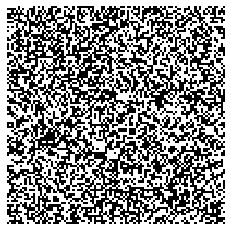

In [2]:
fig, ax = show_conway(grid)

In [3]:
%timeit conway_step(grid)

156 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%pip install snakeviz


Note: you may need to restart the kernel to use updated packages.


In [5]:
%load_ext snakeviz



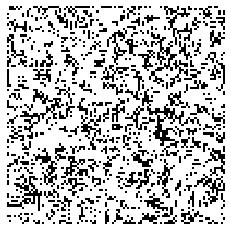

In [6]:
grid = conway_step(grid)
fig, ax = show_conway(grid)

In [7]:
%snakeviz conway_step(grid)

 
*** Profile stats marshalled to file 'C:\\Users\\hcodeur1\\AppData\\Local\\Temp\\tmpb03up77w'. 
Embedding SnakeViz in this document...


## [Cython](https://docs.cython.org)

In [10]:
%load_ext cython

In [11]:
%%cython

from cython.view cimport array as cvarray

import numpy as np
cimport numpy as np

def eval_pixel(
        int row,
        int col,
        int[:, :] grid,
        int[:, :] next_grid):
    """Follows the rules of Conway's game of life to
    flip (or not) a pixel in a grid
    """
    cdef int n = grid.shape[0]
    cdef int m = grid.shape[1]
    cdef int i = max(row-1, 0)
    cdef int j = min(n, row+2)

    cdef int k = max(col-1, 0)
    cdef int l = min(m, col+2)


    cdef int[:, :] sub_grid = grid[i:j, k:l]

    cdef int sum_ = 0
    for u in range(j - i):
        for v in range(k - l):
            sum_ += sub_grid[u, v]

    if grid[row, col] and not (2 < sum_ < 5):
        next_grid[row, col] = 0
    elif sum_ == 3:
        next_grid[row, col] = 1


def conway_step(int[:, :] grid):
    """Applies Conway's rule for every pixel on a grid
    """
    cdef int n = grid.shape[0]
    cdef int m = grid.shape[1]
    cdef int[:, :] next_grid = grid.copy()
    cdef int i, j
    for i in range(n):
        for j in range(m):
            eval_pixel(i, j, grid, next_grid)
    return next_grid


DistutilsPlatformError: Unable to find vcvarsall.bat

## [Numba](https://numba.pydata.org/)

In [12]:
%conda install numba

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\hcodeur1\.conda\envs\formation

  added / updated specs:
    - numba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numba-0.45.0               |   py37hf9181ef_0         3.0 MB
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be INSTALLED:

  llvmlite           pkgs/main/win-32::llvmlite-0.29.0-py37ha925a31_0
  numba              pkgs/main/win-32::numba-0.45.0-py37hf9181ef_0




numba-0.45.0         | 3.0 MB    |            |   0% 
numba-0.45.0         | 3.0 MB    | #3         |  13% 
numba-0.45.0         | 3.0 MB    | ####9      |  50% 
numba-0.45.0         | 3.0 MB    | ########7  |  87% 
numba-0.45.0         | 3.0 MB    | ########## | 100% 
Preparing transaction: ...working... 



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda




In [46]:
import time


In [50]:
time.perf_counter()

1444.479058996

In [16]:
from numba import jit
import time


@jit
def eval_pixel(row, col, grid, next_grid):
    """Follows the rules of Conway's game of life to
    flip (or not) a pixel in a grid
    """

    n, m = grid.shape
    sub_grid = grid[
        max(row-1, 0): min(n, row+2),
        max(col-1, 0): min(m, col+2)]
    if grid[row, col] and not (2 < sub_grid.sum() < 5):
        next_grid[row, col] = 0
    elif sub_grid.sum() == 3:
        next_grid[row, col] = 1

@jit
def conway_step(grid):
    """Applies Conway's rule for every pixel on a grid
    """
    start = time.now()
    n, m = grid.shape

    next_grid = grid.copy()
    
    for i in range(n):
        for j in range(m):
            eval_pixel(i, j, grid, next_grid)
    return next_grid

def conway_loop(grid, ax=None):
    """Play Conways game of life on repeat
    """
    
    while True:
        try:
            grid = conway_step(grid)
            fig, ax = show_conway(grid, None)
            time.sleep(1)

        except KeyboardInterrupt:
            print('Done')
            break

def show_conway(grid, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        fig.clear()
        
    im = ax.imshow(grid, cmap='Greys')
    ax.set_axis_off()
    
    return fig, ax

grid_shape = 100, 100

grid = np.random.randint(0, 2, size=grid_shape, dtype=np.uint8)
#grid[1:4, 3] = 1



In [17]:
conway_step(grid)

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 0]], dtype=uint8)

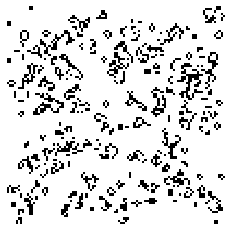

In [45]:
grid = conway_step(grid)
fig, ax = show_conway(grid)

## [Threading](https://docs.python.org/3.7/tutorial/stdlib2.html#multi-threading)

In [54]:
import threading

In [60]:
class ConwayStep(threading.Thread):
    
    def __init__(self, block, grid, next_grid):
        threading.Thread.__init__(self)
        self.block = block
        self.grid = grid
        self.next_grid = next_grid
        
    def run(self):
        start_i, stop_i, start_j, stop_j = self.block
        #print(f'running thred with start at {start_i, start_j}')
        ii, jj = np.meshgrid(
            np.arange(start_i, stop_i),
            np.arange(start_j, stop_j)
        )
        for i, j in zip(ii.ravel(), jj.ravel()):
            eval_pixel(i, j, self.grid, self.next_grid)



def parallel_step(grid, blocks):
    next_grid = grid.copy()

    threads = []
    for b in blocks:
        threads.append(ConwayStep(b, grid, next_grid))
    for th in threads:
        th.start()

    for th in threads:
        th.join()
    
    return next_grid
    


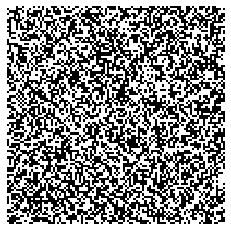

In [61]:
grid_shape = 100, 100
grid = np.random.randint(0, 2, size=grid_shape, dtype=np.uint8)
        

n, m = grid.shape
size_i = n // 2
size_j = m // 2


blocks = [
    (0, size_i, 0, size_j),
    (size_i, n, 0, size_j),
    (0, size_i, size_j, m),
    (size_i, n, size_j, m)
]



fig, ax = show_conway(grid)

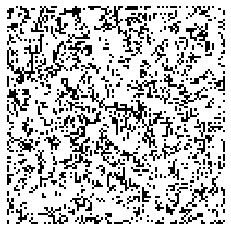

In [62]:
grid = parallel_step(grid, blocks)
fig, ax = show_conway(grid)


In [63]:
%timeit parallel_step(grid, blocks)

150 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
%timeit conway_step(grid)

146 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Multiprocessing

In [66]:
from multiprocessing import Process
import os

def info(title):
    print(title)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())

def f(name):
    info('function f')
    print('hello', name)

info('main line')
p = Process(target=f, args=('bob',))
p.start()
p.join()

main line
module name: __main__
parent process: 3092
process id: 4228


### No (trivialy) shared data!!

In [67]:
class ConwayStep_mp(Process):
    def __init__(self, block, grid, next_grid):
        Process.__init__(self)
        self.block = block
        self.grid = grid
        self.next_grid = next_grid
        
    def run(self):
        start_i, stop_i, start_j, stop_j = self.block
        #print(f'running thred with start at {start_i, start_j}')
        ii, jj = np.meshgrid(
            np.arange(start_i, stop_i),
            np.arange(start_j, stop_j)
        )
        for i, j in zip(ii.ravel(), jj.ravel()):
            eval_pixel(i, j, self.grid, self.next_grid)
        return self.next_grid

def parallel_step_mp(grid, blocks):
    next_grid = grid.copy()

    processes = []
    next_grids = []
    for b in blocks:
        grid_ = grid.copy()
        nex_grid_ = grid.copy()
        nex_grid_ = processes.append(ConwayStep_mp(b, grid_, next_grid_))
    for th in processes:
        th.start()

    for th in processes:
        th.join()
    
    return next_grid
    


In [70]:
from pathlib import Path

In [78]:
data_pth = Path('data/')
jpg_path = data_pth/'todhia_oli.jpg'

In [79]:
jpg_path

WindowsPath('data/todhia_oli.jpg')

In [95]:
[int(s) for s in str(124)]

[1, 2, 4]

In [81]:
assert 1 == 2

AssertionError: 

In [ ]:
hackinscience.org

In [73]:
data_pth.absolute()

WindowsPath('C:/Users/hcodeur1/Desktop/formation_IFPEN-master/data')

In [68]:
%timeit parallel_step_mp(grid, blocks)

BrokenPipeError: [Errno 32] Broken pipe

In [69]:
grid = parallel_step_mp(grid, blocks)
fig, ax = show_conway(grid)

BrokenPipeError: [Errno 32] Broken pipe

### Subprocess, shutils

In [82]:
import subprocess

In [89]:
import shutil

In [ ]:
shutil

In [90]:
import collections

In [91]:
import itertools

In [93]:
for i, j in itertools.product("abc", "cef"):
    print(i, j)

a c
a e
a f
b c
b e
b f
c c
c e
c f


In [87]:
!dir

 Le volume dans le lecteur C n’a pas de nom.
 Le numéro de série du volume est 88C1-10D3

 Répertoire de C:\Users\hcodeur1\Desktop\formation_IFPEN-master

04/10/2019  16:11    <REP>          .
04/10/2019  16:11    <REP>          ..
03/10/2019  17:08            16 170 Chapitre1.ipynb
01/10/2019  15:24           224 775 Chapitre2.ipynb
02/10/2019  15:54         3 033 441 Chapitre3.ipynb
04/10/2019  11:13            82 395 Chapitre3bis.ipynb
04/10/2019  16:11            97 758 Chapitre4.ipynb
04/10/2019  11:57           266 201 Chapitre5.ipynb
30/09/2019  09:03    <REP>          data
30/09/2019  08:55               250 environment.yml
03/10/2019  16:43    <REP>          ifpen_data
01/10/2019  16:39               102 log.log
01/10/2019  16:36                 0 log1.log
30/09/2019  08:55           105 614 notebook_pandas.ipynb
22/01/2019  17:51       174 631 776 original_mono_Result_20171206_103120.3793.mat
09/07/2019  17:45       694 086 157 original_multi_20180424_201836_1500rpm.mat.mat
3

In [88]:
subprocess.run(['dir',])

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable